+ [download dataset](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset/data)
+ items:
    + CRIM - per capita crime rate by town
    + ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    + INDUS - proportion of non-retail business acres per town.
    + CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    + NOX - nitric oxides concentration (parts per 10 million)
    + RM - average number of rooms per dwelling
    + AGE - proportion of owner-occupied units built prior to 1940
    + DIS - weighted distances to five Boston employment centres
    + RAD - index of accessibility to radial highways
    + TAX - full-value property-tax rate per \$10,000
    + PTRATIO - pupil-teacher ratio by town
    + B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    + LSTAT - % lower status of the population
    + MEDV - Median value of owner-occupied homes in $1000's
+ 14 inputs -> 1 output

In [1]:
import random, math, time, os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Observation and Preprocessing

In [2]:
df = pd.read_csv("./housing.csv")
df

,0.00632 18.00 2.310 0 0.5380 6.5750 65.20 4.0900 1 296.0 15.30 396.90 4.98 24.00
0,0.02731 0.00 7.070 0 0.4690 6.4210 78...
1,0.02729 0.00 7.070 0 0.4690 7.1850 61...
2,0.03237 0.00 2.180 0 0.4580 6.9980 45...
3,0.06905 0.00 2.180 0 0.4580 7.1470 54...
4,0.02985 0.00 2.180 0 0.4580 6.4300 58...
...,...
500,0.06263 0.00 11.930 0 0.5730 6.5930 69...
501,0.04527 0.00 11.930 0 0.5730 6.1200 76...
502,0.06076 0.00 11.930 0 0.5730 6.9760 91...
503,0.10959 0.00 11.930 0 0.5730 6.7940 89...


In [3]:
data = []
with open("./housing.csv", "r") as f:
    for line in f.readlines():
        L = list(filter(lambda s:s, line.split(" ")))
        L = list(map(lambda s:float(s.replace('\n','')),L))
        assert len(L)==14
        data.append(L)
data = pd.DataFrame(data)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [4]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
ds = data.describe()
outliers = []
series = pd.Series([True]*len(data))
for i in range(len(data.columns)):
    seriesi = abs(data[0]-ds[0]['mean'])/ds[0]['std'] < 4
    outliers.append( len(data) - seriesi.sum() )
    series = series & seriesi
print(outliers)
print(series.sum())
data1 = data[series].reset_index(drop=True)
data1

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
499


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
495,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
496,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
497,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [6]:
means, stds = data1.mean(axis=0), data1.std(axis=0)
data1 = (data1-means)/stds
data1 #.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.534426,0.276243,-1.272797,-0.274372,-0.129757,0.403283,-0.105890,0.125226,-0.970902,-0.650800,-1.442795,0.435186,-1.073789,0.139621
1,-0.530479,-0.491460,-0.578738,-0.274372,-0.725868,0.183129,0.380991,0.542237,-0.854581,-0.974339,-0.290794,0.435186,-0.479632,-0.124076
2,-0.530483,-0.491460,-0.578738,-0.274372,-0.725868,1.275323,-0.251599,0.542237,-0.854581,-0.974339,-0.290794,0.389133,-1.209474,1.315273
3,-0.529527,-0.491460,-1.291753,-0.274372,-0.820900,1.007993,-0.795342,1.062894,-0.738259,-1.094168,0.123927,0.409501,-1.365154,1.172436
4,-0.522630,-0.491460,-1.291753,-0.274372,-0.820900,1.220999,-0.496816,1.062894,-0.738259,-1.094168,0.123927,0.435186,-1.023800,1.480084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,-0.523837,-0.491460,0.129903,-0.274372,0.172618,0.429015,0.032711,-0.640902,-0.970902,-0.788604,1.183768,0.379628,-0.403935,-0.036177
495,-0.527101,-0.491460,0.129903,-0.274372,0.172618,-0.247173,0.302806,-0.731759,-0.970902,-0.788604,1.183768,0.435186,-0.488202,-0.233950
496,-0.524188,-0.491460,0.129903,-0.274372,0.172618,0.976542,0.811010,-0.788812,-0.970902,-0.788604,1.183768,0.435186,-0.979524,0.128634
497,-0.515006,-0.491460,0.129903,-0.274372,0.172618,0.716360,0.750594,-0.683549,-0.970902,-0.788604,1.183768,0.396149,-0.859550,-0.080127


In [7]:
R = list(range(len(data1)))
random.shuffle(R)

dataTrain, dataVal = data1.loc[R[:int(len(R)*0.8)]], data1.loc[R[int(len(R)*0.8):]]
print(dataTrain.shape, dataVal.shape)
xTrain, yTrain = np.array(dataTrain[ list(dataTrain.columns)[:13] ]), np.array(dataTrain[[13]])
xVal, yVal = np.array(dataVal[ list(dataVal.columns)[:13] ]), np.array(dataVal[[13]])
print(xTrain.shape, yTrain.shape, xVal.shape, yVal.shape)
xTrain[0], yTrain[0]

(399, 14) (100, 14)
(399, 13) (399, 1) (100, 13) (100, 1)


(array([-0.52706949, -0.49145965, -1.13719333, -0.27437177, -0.80362134,
        -0.21286324, -1.27866897,  0.97322529, -0.62193702,  0.15205586,
        -0.70551401,  0.11462477, -0.48677363]),
 array([-0.3218492]))

### Dataset and dataloader

In [8]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        assert len(self.X), len(self.y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        x = torch.Tensor(self.X[index]).to('cuda')
        y = torch.Tensor(self.y[index]).to('cuda')
        return x,y
    
trainDataset = MyDataset(xTrain, yTrain)
valDataset = MyDataset(xVal, yVal)
print(trainDataset[0])

(tensor([-0.5271, -0.4915, -1.1372, -0.2744, -0.8036, -0.2129, -1.2787,  0.9732,
        -0.6219,  0.1521, -0.7055,  0.1146, -0.4868], device='cuda:0'), tensor([-0.3218], device='cuda:0'))


In [9]:
batch_size = 16
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, pin_memory=False)
valDataLoader = DataLoader(valDataset, batch_size=batch_size, pin_memory=False)
# stepPerEpoch = len(trainDataLoader)
print( len(trainDataLoader), len(valDataLoader) ) # 399/16=24 # 100/16=6

25 7


### Neural network

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1  = nn.Linear(13, 64)
        self.dense2  = nn.Linear(64, 64)
        self.dense3  = nn.Linear(64, 1)
    def forward(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

model = MyModel().to('cuda')
print( model )

D = model.state_dict()
print( [(name,D[name].shape,D[name].numel()) for name in D] )
P = model.named_parameters()
print( [(name,weight.shape,weight.numel()) for name,weight in P] )

with torch.no_grad():
    testInput = torch.rand(2,13).to('cuda')
    start = time.time()
    pred = model(testInput)
    print( round(time.time()-start,5), pred )

MyModel(
  (dense1): Linear(in_features=13, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=64, bias=True)
  (dense3): Linear(in_features=64, out_features=1, bias=True)
)
[('dense1.weight', torch.Size([64, 13]), 832), ('dense1.bias', torch.Size([64]), 64), ('dense2.weight', torch.Size([64, 64]), 4096), ('dense2.bias', torch.Size([64]), 64), ('dense3.weight', torch.Size([1, 64]), 64), ('dense3.bias', torch.Size([1]), 1)]
[('dense1.weight', torch.Size([64, 13]), 832), ('dense1.bias', torch.Size([64]), 64), ('dense2.weight', torch.Size([64, 64]), 4096), ('dense2.bias', torch.Size([64]), 64), ('dense3.weight', torch.Size([1, 64]), 64), ('dense3.bias', torch.Size([1]), 1)]
0.00209 tensor([[0.2049],
        [0.1705]], device='cuda:0')


In [11]:
print( list(model.named_parameters())[-1][1] ) # last layer # weight # every time will different
torch.save({'model_state_dict':model.state_dict(),'epoch':0,'loss':99}, 'init.pth')

Parameter containing:
tensor([0.0694], device='cuda:0', requires_grad=True)


In [12]:
model = MyModel().to('cuda')
print( list(model.named_parameters())[-1][1] )

checkpoint = torch.load('./init.pth')
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print( list(model.named_parameters())[-1][1], epoch, loss )

Parameter containing:
tensor([0.0083], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0694], device='cuda:0', requires_grad=True) 0 99


### Optimizer

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

### Loss / Criterion

In [14]:
lossFunc = nn.MSELoss()
xReal = torch.Tensor([[0,1,2],[3,4,5]])
xPred = torch.Tensor([[0,1,2],[3,4,3]])

loss = lossFunc(xReal, xPred) # (5-3)**2/6
print( loss )

tensor(0.6667)


### Training

In [15]:
epochs = 100
output_dir = "."
save_per_ep = 30

os.makedirs(output_dir, exist_ok=True)
history = {"trainLossL":[], "valLossL":[]}
for ep in range(epochs):
    print(f"Epoch: {ep+1}/{epochs}")
    # train
    trainLoss= 0.
    for i,(X,y) in enumerate(trainDataLoader):
        optimizer.zero_grad()    # zero the parameter gradients
        pred = model(X)          # predict
        loss = lossFunc(y,pred)  # loss
        loss.backward()          # calculate loss to update model.grad
        optimizer.step()         # update parameters
        trainLoss += loss.item() / len(trainDataset)
        print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}", end="")
    history["trainLossL"].append(trainLoss)
    # save
    if ep%save_per_ep==0 or ep==epochs-1:
        torch.save({'model_state_dict':model.state_dict(),'epoch':ep,'loss':trainLoss}, f"{output_dir}/ckpt-{ep}.pth")
    # validation
    valLoss = 0.
    for i,(X,y) in enumerate(valDataLoader):
        with torch.no_grad():
            pred = model(X)
            loss = lossFunc(pred,y)
            valLoss += loss.item() / len(valDataset)
            print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}", end="")
    history["valLossL"].append(valLoss)
    print()

Epoch: 1/100
batch=7/7, valLoss=0.051724449
Epoch: 2/100
batch=7/7, valLoss=0.041413300
Epoch: 3/100
batch=7/7, valLoss=0.036002788
Epoch: 4/100
batch=7/7, valLoss=0.032522517
Epoch: 5/100
batch=7/7, valLoss=0.030042328
Epoch: 6/100
batch=7/7, valLoss=0.028222187
Epoch: 7/100
batch=7/7, valLoss=0.026882081
Epoch: 8/100
batch=7/7, valLoss=0.025912002
Epoch: 9/100
batch=7/7, valLoss=0.025211942
Epoch: 10/100
batch=7/7, valLoss=0.024701896
Epoch: 11/100
batch=7/7, valLoss=0.024311860
Epoch: 12/100
batch=7/7, valLoss=0.024021831
Epoch: 13/100
batch=7/7, valLoss=0.023801806
Epoch: 14/100
batch=7/7, valLoss=0.023611785
Epoch: 15/100
batch=7/7, valLoss=0.023461767
Epoch: 16/100
batch=7/7, valLoss=0.023321751
Epoch: 17/100
batch=7/7, valLoss=0.023201737
Epoch: 18/100
batch=7/7, valLoss=0.023101724
Epoch: 19/100
batch=7/7, valLoss=0.023001713
Epoch: 20/100
batch=7/7, valLoss=0.022901702
Epoch: 21/100
batch=7/7, valLoss=0.022811693
Epoch: 22/100
batch=7/7, valLoss=0.022731684
Epoch: 23/100
batch

### Training result

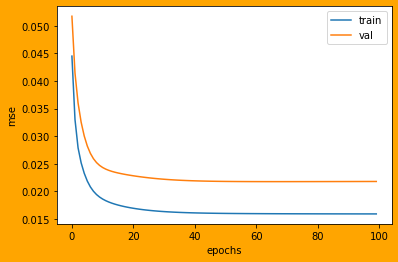

In [16]:
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['trainLossL'])
plt.plot(history['valLossL'])
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend(labels=['train','val'])
plt.show()

### Predict

In [17]:
"""
model.eval()            # Turn off some layers such as dropout, batch normalization for model inference
with torch.no_grad():   # Turn off gradient calculation
    pass
"""
with torch.no_grad():
    realL, predL = [], []
    for X,y in valDataLoader:
        realL += list( y.cpu().detach().numpy().reshape(-1) )
        pred = model(X)
        predL += list( pred.cpu().detach().numpy().reshape(-1) )
        
realL = list(map(lambda x:round(x*stds[13]+stds[13],4),realL))
predL = list(map(lambda x:round(x*stds[13]+stds[13],4),predL))
errL  = [ round(1-abs(pred-real)/(stds[13]*2),4) for real,pred in zip(realL,predL) ]
for real,pred,err in zip(realL,predL,errL):
    print(real,pred,err)

5.2721 10.4303 0.7166
36.3721 17.414 -0.0415
4.7721 5.2512 0.9737
6.5721 8.7553 0.8801
-6.4279 -4.0855 0.8713
18.7721 20.9106 0.8825
10.6721 15.2606 0.7479
22.5721 14.3533 0.5485
11.1721 12.4727 0.9285
36.3721 29.4099 0.6175
-2.1279 0.7754 0.8405
21.4721 21.5683 0.9947
3.0721 7.0551 0.7812
10.5721 11.3475 0.9574
11.3721 9.0059 0.87
7.7721 7.9417 0.9907
0.8721 0.7024 0.9907
3.0721 5.8815 0.8457
2.0721 1.0693 0.9449
-5.5279 -9.4988 0.7819
-0.3279 6.6062 0.6191
-4.1279 -0.4099 0.7957
7.8721 10.0283 0.8815
6.6721 8.7731 0.8846
5.1721 7.5467 0.8695
-2.6279 0.7726 0.8132
-3.4279 2.5535 0.6714
8.5721 10.6772 0.8844
-4.8279 -10.3302 0.6977
9.4721 10.7467 0.93
6.9721 7.6156 0.9646
14.5721 19.2934 0.7406
11.0721 9.3777 0.9069
8.7721 9.963 0.9346
5.4721 6.0624 0.9676
23.5721 19.3368 0.7673
3.8721 3.635 0.987
19.4721 19.0128 0.9748
0.2721 0.2144 0.9968
1.9721 2.4866 0.9717
9.4721 11.3054 0.8993
5.7721 9.7438 0.7818
-0.6279 3.7109 0.7616
4.7721 2.2685 0.8625
7.1721 4.7793 0.8685
3.1721 5.3085 0.882

In [18]:
round(sum(errL)/len(errL),4)

0.8091

### Transfer learning

In [22]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1  = nn.Linear(13, 64)
        self.dense2  = nn.Linear(64, 64)
        self.dense3  = nn.Linear(64, 1)
    def forward(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

model = MyModel().to('cuda')
print( model )

MyModel(
  (dense1): Linear(in_features=13, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=64, bias=True)
  (dense3): Linear(in_features=64, out_features=1, bias=True)
)


In [24]:
checkpoint = torch.load("./ckpt-99.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [25]:
with torch.no_grad():
    realL, predL = [], []
    for X,y in valDataLoader:
        realL += list( y.cpu().detach().numpy().reshape(-1) )
        pred = model(X)
        predL += list( pred.cpu().detach().numpy().reshape(-1) )
        
realL = list(map(lambda x:round(x*stds[13]+stds[13],4),realL))
predL = list(map(lambda x:round(x*stds[13]+stds[13],4),predL))
errL  = [ round(1-abs(pred-real)/(stds[13]*2),4) for real,pred in zip(realL,predL) ]
#for real,pred,err in zip(realL,predL,errL):
#    print(real,pred,err)
round(sum(errL)/len(errL),4)

0.8091

### More:
+ modularization all processes
+ specify the weight, then load it after initialize the model